In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 3b
commitnumber = 5014a19
conc = 0.0004
dv = 0.01
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [5, 2]
nv = 100
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250)]
tsfc = 294
vmax = 720
vmin = 620
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66)]
wgt = [(0, 0.6, 0.5, 0.7, 0.8), (0.8, 0.7)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

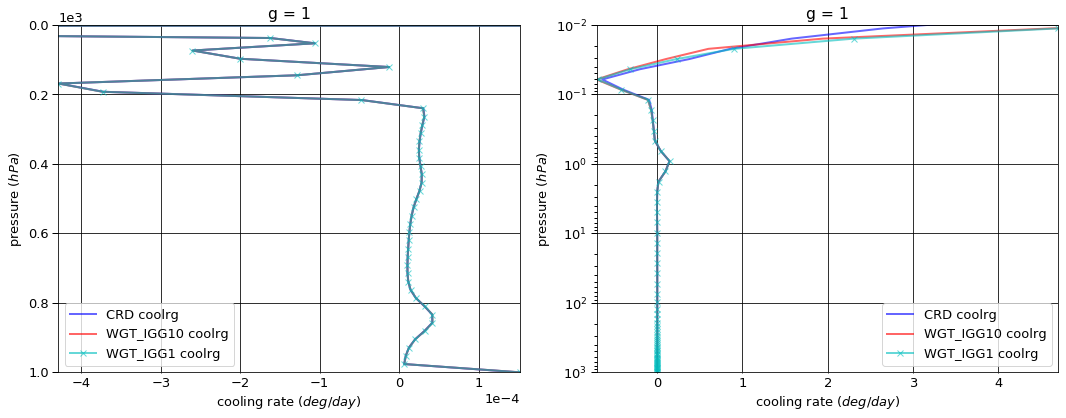

# Figure: cooling rate g-group 2

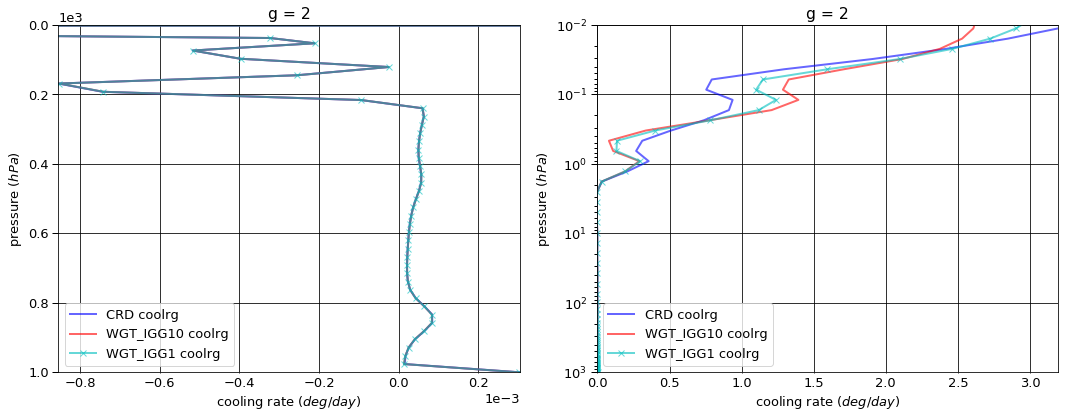

# Figure: cooling rate g-group 3

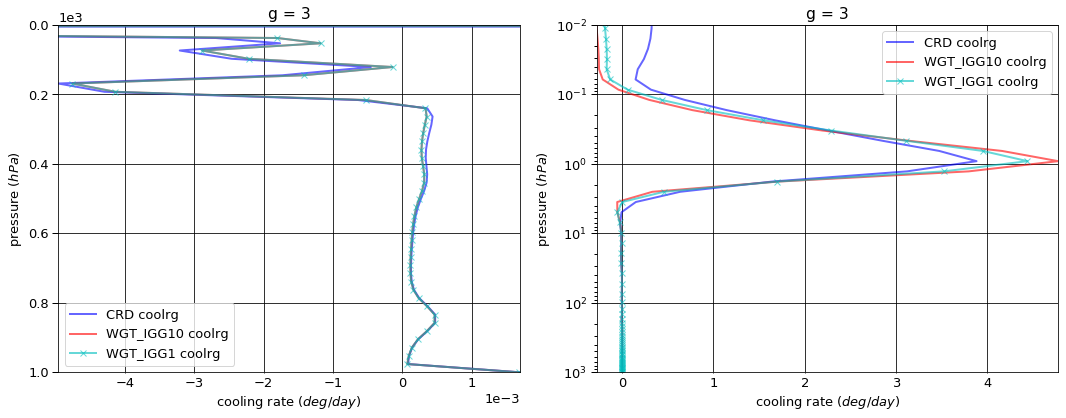

# Figure: cooling rate g-group 4

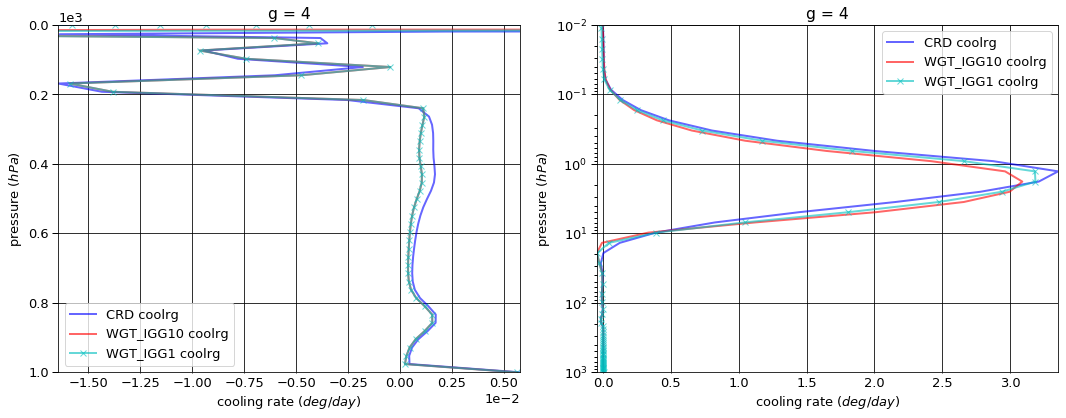

# Figure: cooling rate g-group 5

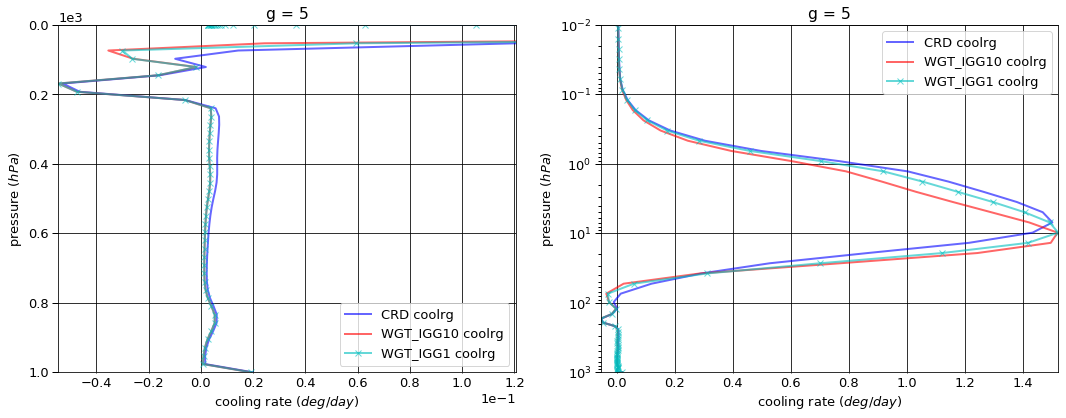

# Figure: cooling rate g-group 6

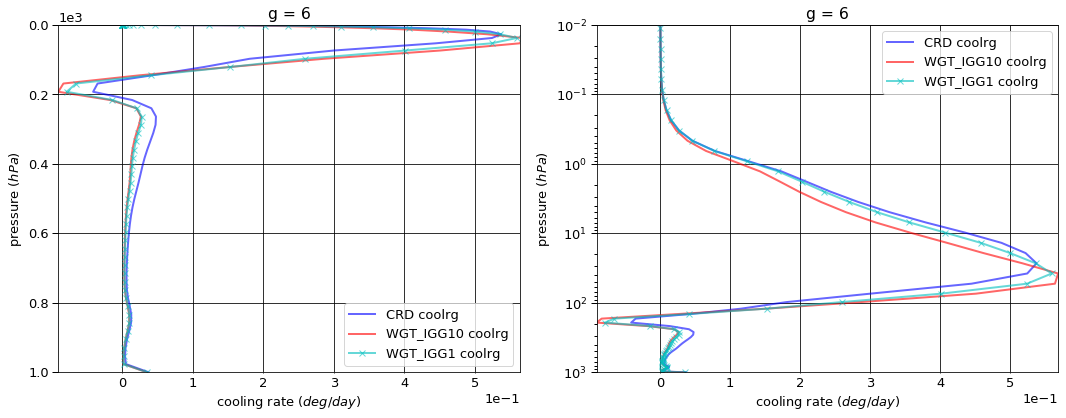

# Figure: cooling rate g-group 7

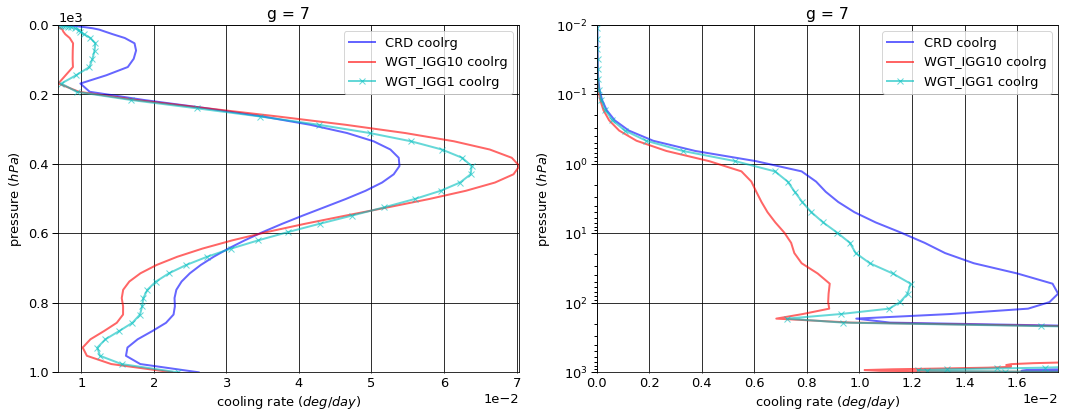

# Figure: cooling rate g-group total

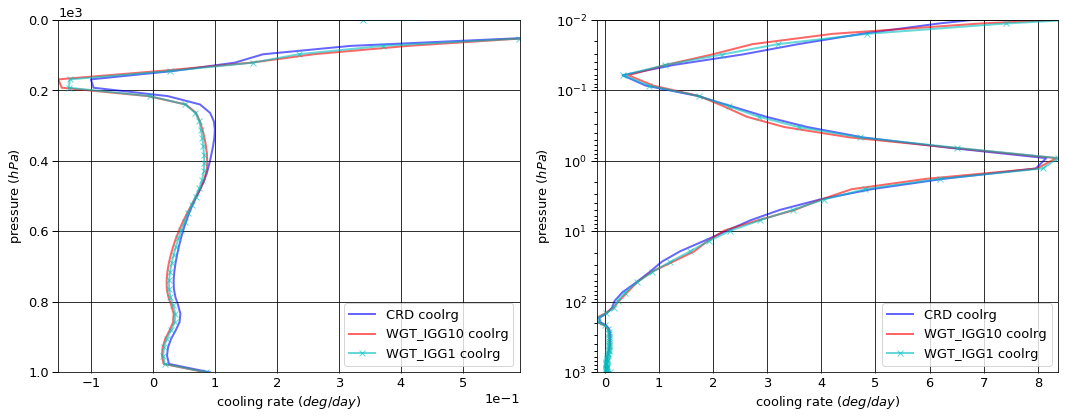

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.024301   0.000000 -0.024301
  1013.0   76     -0.088302   0.087885 -0.000417
2 0.0      1      -0.070043   0.000000 -0.070043
  1013.0   76     -0.176094   0.175247 -0.000847
3 0.0      1      -0.645632   0.000000 -0.645632
  1013.0   76     -0.982193   0.977477 -0.004716
4 0.0      1      -1.851979   0.000000 -1.851979
  1013.0   76     -3.276071   3.259209 -0.016862
5 0.0      1      -4.536145   0.000000 -4.536145
  1013.0   76    -11.239984  11.179319 -0.060665
6 0.0      1      -6.882909   0.000000 -6.882909
  1013.0   76    -20.333329  20.213925 -0.119404
7 0.0      1      -3.758429   0.000000 -3.758429
  1013.0   76     -7.868865   7.641766 -0.227099


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.024543   0.000000 -0.024543
  1013.0   76     -0.088575   0.088155 -0.000420
2 0.0      1      -0.062940   0.000000 -0.062940
  1013.0   76     -0.176052   0.175217 -0.000835
3 0.0      1      -0.667671   0.000000 -0.667671
  1013.0   76     -0.982279   0.977619 -0.004660
4 0.0      1      -1.913188   0.000000 -1.913188
  1013.0   76     -3.283132   3.267555 -0.015577
5 0.0      1      -4.547578   0.000000 -4.547578
  1013.0   76    -11.254628  11.201230 -0.053398
6 0.0      1      -6.563836   0.000000 -6.563836
  1013.0   76    -20.338877  20.241389 -0.097488
7 0.0      1      -3.644554   0.000000 -3.644554
  1013.0   76     -7.841295   7.718501 -0.122794


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.024566   0.000000 -0.024566
  1013.0   76     -0.088575   0.088155 -0.000420
2 0.0      1      -0.063956   0.000000 -0.063956
  1013.0   76     -0.176052   0.175217 -0.000835
3 0.0      1      -0.659069   0.000000 -0.659069
  1013.0   76     -0.982279   0.977619 -0.004660
4 0.0      1      -1.907495   0.000000 -1.907495
  1013.0   76     -3.283132   3.267555 -0.015577
5 0.0      1      -4.562618   0.000000 -4.562618
  1013.0   76    -11.254628  11.201230 -0.053398
6 0.0      1      -6.608052   0.000000 -6.608052
  1013.0   76    -20.338877  20.239510 -0.099367
7 0.0      1      -3.699738   0.000000 -3.699738
  1013.0   76     -7.841295   7.700001 -0.141293


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000242  0.000000 -0.000242
  1013.0   76    -0.000273  0.000270 -0.000004
2 0.0      1      0.007104  0.000000  0.007104
  1013.0   76     0.000042 -0.000030  0.000012
3 0.0      1     -0.022039  0.000000 -0.022039
  1013.0   76    -0.000086  0.000141  0.000055
4 0.0      1     -0.061209  0.000000 -0.061209
  1013.0   76    -0.007060  0.008346  0.001285
5 0.0      1     -0.011433  0.000000 -0.011433
  1013.0   76    -0.014644  0.021911  0.007267
6 0.0      1      0.319073  0.000000  0.319073
  1013.0   76    -0.005548  0.027464  0.021916
7 0.0      1      0.113875  0.000000  0.113875
  1013.0   76     0.027570  0.076735  0.104305


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000266  0.000000 -0.000266
  1013.0   76    -0.000273  0.000270 -0.000004
2 0.0      1      0.006087  0.000000  0.006087
  1013.0   76     0.000042 -0.000030  0.000012
3 0.0      1     -0.013437  0.000000 -0.013437
  1013.0   76    -0.000086  0.000141  0.000055
4 0.0      1     -0.055516  0.000000 -0.055516
  1013.0   76    -0.007060  0.008346  0.001285
5 0.0      1     -0.026472  0.000000 -0.026472
  1013.0   76    -0.014644  0.021911  0.007267
6 0.0      1      0.274856  0.000000  0.274856
  1013.0   76    -0.005548  0.025585  0.020037
7 0.0      1      0.058690  0.000000  0.058690
  1013.0   76     0.027570  0.058235  0.085805

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer           
1 0.000312    1      99.317818
  1001.112500 75      0.000151
2 0.000312    1       3.876770
  1001.112500 75      0.000304
3 0.000312    1       0.200425
  1001.112500 75      0.001693
4 0.000312    1      -0.019980
  1001.112500 75      0.005758
5 0.000312    1       0.003399
  1001.112500 75      0.019884
6 0.000312    1       0.000269
  1001.112500 75      0.037664
7 0.000312    1       0.000015
  1001.112500 75      0.026180


WGT_IGG10


coolrg
g pressure    layer           
1 0.000312    1      35.486292
  1001.112500 75      0.000152
2 0.000312    1       2.175034
  1001.112500 75      0.000302
3 0.000312    1      -0.382104
  1001.112500 75      0.001684
4 0.000312    1      -0.015983
  1001.112500 75      0.005629
5 0.000312    1       0.002908
  1001.112500 75      0.019298
6 0.000312    1       0.000253
  1001.112500 75      0.035089
7 0.000312    1       0.000007
  1001.112500 75      0.022518


WGT_IGG1


coolrg
g pressure    layer           
1 0.000312    1      39.657253
  1001.112500 75      0.000152
2 0.000312    1       2.828189
  1001.112500 75      0.000302
3 0.000312    1      -0.317776
  1001.112500 75      0.001684
4 0.000312    1      -0.027774
  1001.112500 75      0.005629
5 0.000312    1       0.002604
  1001.112500 75      0.019298
6 0.000312    1       0.000280
  1001.112500 75      0.035459
7 0.000312    1       0.000014
  1001.112500 75      0.023302


WGT_IGG10 - CRD


coolrg
g pressure    layer           
1 0.000312    1     -63.831526
  1001.112500 75      0.000001
2 0.000312    1      -1.701737
  1001.112500 75     -0.000002
3 0.000312    1      -0.582529
  1001.112500 75     -0.000009
4 0.000312    1       0.003997
  1001.112500 75     -0.000128
5 0.000312    1      -0.000491
  1001.112500 75     -0.000586
6 0.000312    1      -0.000016
  1001.112500 75     -0.002575
7 0.000312    1      -0.000007
  1001.112500 75     -0.003663


WGT_IGG1 - CRD


coolrg
g pressure    layer           
1 0.000312    1     -59.660565
  1001.112500 75      0.000001
2 0.000312    1      -1.048581
  1001.112500 75     -0.000002
3 0.000312    1      -0.518201
  1001.112500 75     -0.000009
4 0.000312    1      -0.007794
  1001.112500 75     -0.000128
5 0.000312    1      -0.000795
  1001.112500 75     -0.000586
6 0.000312    1       0.000010
  1001.112500 75     -0.002205
7 0.000312    1      -0.000001
  1001.112500 75     -0.002878

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.769437,0.000000,-17.769437
1013.0,76,-43.964838,43.534829,-0.430009



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.424309,0.000000,-17.424309
1013.0,76,-43.964838,43.669665,-0.295173



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.525494,0.000000,-17.525494
1013.0,76,-43.964838,43.649286,-0.315552



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.451279e-01,0.000000,0.345128
1013.0,76,4.490000e-07,0.134836,0.134836



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.439435e-01,0.000000,0.243944
1013.0,76,4.490000e-07,0.114458,0.114457


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,103.378716
1001.112500,75,0.091634



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,37.266408
1001.112500,75,0.084672



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,42.142789
1001.112500,75,0.085827



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-66.112308
1001.112500,75,-0.006962



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-61.235927
1001.112500,75,-0.005807


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.0020,0.002015
2,0.0040,0.004004
3,0.0223,0.022342
4,0.0743,0.074676
5,0.2551,0.255992
6,0.4623,0.462617
7,0.1800,0.178354


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.501193e-18
2,4.401090e-19
3,2.582202e-20
4,1.515026e-21
5,8.888939e-23
6,5.206866e-23
7,3.059927e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.501193e-18,NaN,0.0020,0.002015,0.0020,0.002015,1.0
2,4.401090e-19,0.058672,0.0040,0.004004,0.0060,0.006019,1.0
3,2.582202e-20,0.058672,0.0223,0.022342,0.0283,0.028361,1.0
4,1.515026e-21,0.058672,0.0743,0.074676,0.1026,0.103038,1.0
5,8.888939e-23,0.058672,0.2551,0.255992,0.3577,0.359029,1.0
6,5.206866e-23,0.585769,0.4623,0.462617,0.8200,0.821646,10.0
7,3.059927e-24,0.058767,0.1800,0.178354,1.0000,1.000000,10.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
